# Image transformation: Edge detection

A crucial part of computer vision, and interpretation of what is in images is edge detection. We will definitely need this in the robot. It will be critical both to follow lines, but also to find objects such as doors and corners of walls.

This notebook looks at using Sobel filters, aka Sobel–Feldman operators, to find edges. Once the edges are found in the image, we will then use a Hough transform to describe these edges. We will introduce a new example, a cube.

This is a good way to practice fundamentals, this time we are going to go through:

1. Filters and kernels to transform images
2. Vectors and matrices
3. Hough transforms
4. Convolution, from first principles

This time lets start by describing the theory.

## Edge detection theory

In this exercise we want to be able to take an image, find the edges and then be able to describe the edges which are lines, by knowing their locations. The steps in doing this are:

1. Sobel filter for edge detection, making a binary image with black as the edge, and white and non edge space.
2. Hough transform, creating an accumulator - an array transforming the edges image described by x and y, to an image describing these the lines going through these edges pixels.
3. Extracting the lines in the original image from this accumulator.

### Sobel  filters
In edge detection, the first step is to transform the image, in to something where the edges are one colour or shade, and the space that is not an edge is another colour. To do this, we apply Sobel filter to the image.

To understand filtering, we need to start by understanding convolution. Lets start by looking at what an image looks as an array. This is a 10 by 12 image, where the y direction is defined as increasing y in the down direction, and the x direction is described by increasing x in the right direction.   

\begin{equation*}
\mathbf{A}  = \begin{bmatrix}
10 & 12 & 14 & 17 & 11 & 27 & 40 & 12 & 34 & 17 & 14 & 12 & 10\\
40 & 13 & 14 & 47 & 10 & 21 & 40 & 12 & 34 & 17 & 14 & 12 & 10\\
51 & 14 & 14 & 57 & 10 & 25 & 40 & 12 & 34 & 17 & 14 & 12 & 10\\
50 & 15 & 14 & 67 & 10 & 23 & 41 & 12 & 34 & 17 & 14 & 12 & 10\\
17 & 16 & 14 & 77 & 11 & 24 & 52 & 12 & 34 & 17 & 14 & 12 & 10\\
12 & 17 & 14 & 77 & 11 & 23 & 57 & 12 & 34 & 17 & 14 & 12 & 10\\
30 & 18 & 14 & 77 & 10 & 24 & 78 & 12 & 34 & 17 & 14 & 12 & 10\\
19 & 19 & 14 & 67 & 10 & 25 & 67 & 12 & 34 & 17 & 14 & 12 & 10\\
18 & 19 & 14 & 57 & 10 & 30 & 71 & 12 & 34 & 17 & 14 & 12 & 10\\
17 & 19 & 14 & 47 & 11 & 31 & 80 & 12 & 34 & 17 & 14 & 12 & 10\\
\end{bmatrix}
\end{equation*}

The filter that we want to convolve it with we call $\mathbf{K}$:

\begin{equation*}
\mathbf{K}  = \begin{bmatrix}
k_{i-1,j-1} & k_{i-1,j} & k_{i-1,j+1}\\
k_{i,j-1} & k_{i,j} & k_{i,j+1}\\
k_{i+1,j-1} & k_{i+1,j} & k_{i+1,j+1}\\
\end{bmatrix} = \frac{1}{9}\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{bmatrix}
\end{equation*}

where the filter can be of any size, but here it is a 3 by 3 kernel, which is an averaging filter. So we now define the convolution as:

\begin{equation*}
\mathbf{C}  = \mathbf{K} * \mathbf{A}
\end{equation*}

In principle this means that for every pixel in the image, we make a 3 by 3 matrix centered around the pixel. For each element of this 3 by 3 image matrix, we multiply it by the corresponding kernel element, namely the one in the same position in the matrix. Finally we sum it up. This can be written as: 

\begin{equation*}
c_{i,j}  = \begin{bmatrix}
k_{i-1,j-1} & k_{i-1,j} & k_{i-1,j+1}\\
k_{i,j-1} & k_{i,j} & k_{i,j+1}\\
k_{i+1,j-1} & k_{i+1,j} & k_{i+1,j+1}\\
\end{bmatrix} * \begin{bmatrix}
a_{i-1,j-1} & a_{i-1,j} & a_{i-1,j+1}\\
a_{i,j-1} & a_{i,j} & a_{i,j+1}\\
a_{i+1,j-1} & a_{i+1,j} & a_{i+1,j+1}\\
\end{bmatrix}
\end{equation*}

which can be calculated by reshaping the kernel and image selection to a 1 by 9 and 9 by 1 matrix respectively, and taking the dot product. 

\begin{equation*}
c_{i,j}  = \begin{bmatrix}
k_{i-1,j-1} & k_{i-1,j} & k_{i-1,j+1} & k_{i,j-1} & k_{i,j} & k_{i,j+1} & k_{i+1,j-1} & k_{i+1,j} & k_{i+1,j+1}\\
\end{bmatrix} . \begin{bmatrix}
a_{i-1,j-1} \\ a_{i-1,j} \\ a_{i-1,j+1}\\
a_{i,j-1} \\ a_{i,j} \\ a_{i,j+1}\\
a_{i+1,j-1} \\ a_{i+1,j} \\ a_{i+1,j+1}\\
\end{bmatrix}
\end{equation*}

We then repeat this for each pixel in the image. Of course the edges pose a problem, and can either be ignored, or a padding of pixels can be added to the edges of the image. 

By example if we look at the fourth row and fifth column of our image, and convolve it with an average filter. 

\begin{equation*}
\mathbf{A_{4,5}}  = \begin{bmatrix}
57 & 10 & 25\\
67 & 10 & 23\\
77 & 11 & 24\\
\end{bmatrix}
\end{equation*}


\begin{equation*}
\mathbf{C_{4,5}}  = \frac{1}{9}\begin{bmatrix}
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\
\end{bmatrix}.\begin{bmatrix}
57 \\ 10 \\ 25\\
67 \\ 10 \\ 23\\
77 \\ 11 \\ 24\\
\end{bmatrix} = \frac{307}{9}
\end{equation*}

The sobel filter is a 3 by 3 kernel which is convolved with the image of interest. The convolution output is effectively an approximation to the derivative at that point. There are two different directions for the kernel to be applied, where $\mathbf{S_{x}}$ and $\mathbf{S_{y}}$, are the kernels which give the vertical and horizontal derivatives $\mathbf{G_{x}}$ and $\mathbf{G_{y}}$ respectively.

\begin{equation*}
\mathbf{G_{x}}  = \mathbf{S_{x}} * A = \begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1
\end{bmatrix} * A
\end{equation*}

\begin{equation*}
\mathbf{G_{y}}  = \mathbf{S_{y}} * A = \begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
+1 & +2 & +1
\end{bmatrix} * A
\end{equation*}

where $\mathbf{A}$ is the image.

In the end we do not want the the gradient in each direction, but the magnitude in total. Thus we end up with $\mathbf{G}$:

\begin{equation*}
\mathbf{G}  =  \sqrt{ \mathbf{G_{y}^{2}} + \mathbf{G_{x}^{2}} }
\end{equation*}


### Hough transforms

The sobel filter gives us an image of the edges, but it does not describe the edges in the images in any way that we can make use of. The edges are simply differently coloured pixels. For us to extract some information out of the image we will need to apply a Hough transform.

In the most simple way, in the image space, a straight line can be described by the equation:

\begin{equation*}
y  =  \mathbf{m}.x  +  \mathbf{c}
\end{equation*}

where the two parameters $\mathbf{m}$ and $\mathbf{c}$ are the slope and the $y$ intercept respectively. Thus, in parameter space $\mathbf{m}-\mathbf{c}$, this straight line could be described by a single point $(\mathbf{m}, \mathbf{c})$. Lets see what this means. Let us take three points in the image, $(x_{1}, y_{1})$, $(x_{2}, y_{2})$, and $(x_{3}, y_{3})$. We can define three straight lines between them. Each of these straight lines has a different slope and y intercept, and can be described by in the parameter space as three seperate points. 

<img src="4-fig1.png">
Fig.1 The three points $(x_{1}, y_{1})$, $(x_{2}, y_{2})$, and $(x_{3}, y_{3})$, shown in th Image space and the Parameter space.

Now imagine that point $(x_{3}, y_{3})$ was moved, so that it sat on the line between $(x_{1}, y_{1})$ and $(x_{2}, y_{2})$. In the image space all three points would have different $x$ and $y$ coordinates, but as now all three lines would have the same slope and intercept, in the parameter space there would be three points with the same $\mathbf{m}$ and $\mathbf{c}$ coordinates. It is this very feature, that makes that the Hough transform takes use of in edge detection.

In the Hough transform, each pixel in the image which was determined to be an edge pixel is looked at in turn. Every point has a series of lines drawn through it. The slope and y intercept of each line passing through the point is noted, and registered a vote in an "Accumlator". After each edge pixel has been looked at, the $\mathbf{m}$ and $\mathbf{c}$ values in the Accumulator with the most number of votes is the straight line passing through the line formed by the edge pixels. 

However a vertical line poses a problem, as the value of m would be undefined. Thus we can fall on to the Hesse normal form of the line:

\begin{equation*}
\mathbf{r}  =  x.cos\boldsymbol{\theta} + y.sin\boldsymbol{\theta}
\end{equation*}

where now in parameter space is described by a single point $(\mathbf{r}, \boldsymbol{\theta})$.

## Practice

We can now employ these into practice. We begin by, as we always do, by downloading the libraries we will need, and downloading the image.

In [1]:
import requests
from io import BytesIO
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import timeit
from scipy.linalg import null_space
from mpl_toolkits.axes_grid1 import make_axes_locatable

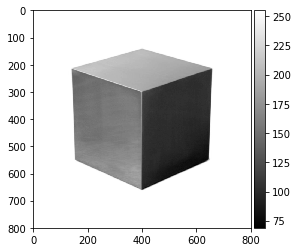

In [2]:
# make sure that we are plotting inline
%matplotlib inline

# make a function for plotting the images
def plotimg(img):
    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(img, cmap='gray')
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

# define the url of the image of interest and download the image
url = "https://secure.img1-fg.wfcdn.com/im/07130976/resize-h800-w800%5Ecompr-r85/1902/1902870/Stainless+Steel+Cube+End+Table.jpg"
response = requests.get(url)

# open the image, and convert to grayscale
raw_img = Image.open(BytesIO(response.content)).convert('LA')
raw_img = raw_img.filter(ImageFilter.GaussianBlur(1))
# make image into a numpy array, strip out only the 1st layer
img = np.array(raw_img)[:,:,0]

# plot the image
plotimg(img)

### Sobel filtering
Lets begin by defining the sobel filter

In [3]:
# the sobel filter for horizontal derivative
sobel_filter_h = np.array([[-1,  0,  1],
                           [-2,  0,  2],
                           [-1,  0,  1]])

# the sobel filter for vertical derivative
sobel_filter_v = np.array([[-1, -2, -1],
                           [ 0,  0,  0],
                           [ 1,  2,  1]])

With the filters defined, we can convolve the filter with the image. We then plot both the full image and a small section of it around a edge. 

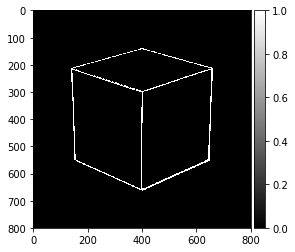

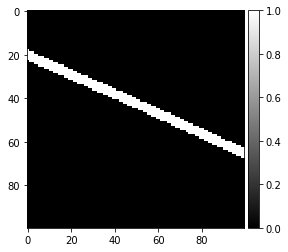

In [4]:
def sobeltrans(img, threshold):
    # get the size of the image
    ymax, xmax = img.shape

    # make up a blank array for the edge image 
    img_edge = np.zeros((ymax, xmax))

    # cycle through the image first by the y direction then x.
    for y in list(range(1, ymax-1)):
        for x in list(range(1, xmax-1)):
            # get the pixels around the pixel of interest
            img_xy = img[y-1:y+2,x-1:x+2]
            # result the sobel filter in each direction
            Gx = img_xy.reshape(1,9) @ sobel_filter_v.reshape(9,1)
            Gy = img_xy.reshape(1,9) @ sobel_filter_h.reshape(9,1)
            # find the absolute ammount.
            G = math.sqrt(Gx**2 + Gy**2)
            # threshold out the noise
            if G > threshold:
                img_edge[y, x] = 1
    return img_edge

# set a threshold to cut out soft edges and noise
threshold = 50

# run the sobel function
img_edge = sobeltrans(img, threshold)

# plot the image
plotimg(img_edge)

# define a small subsection of the image
mini_img_edge = img_edge[550:650, 200:300]
# plot it
plotimg(mini_img_edge) 

Great. Clearly we have found the edges, and are now ready to find the equations for the edges so we can map them. Lets write out the theory into a function that we can use to do the Hough Transform.

In [7]:
def houghtrans(img_edge):
    # range of thetas in radians based on the angle from the axis
    thetas = np.deg2rad(np.arange(-90,90))
    # range of radius from -max_radius to plus max_radius
    ymax, xmax = img_edge.shape
    max_radius = math.trunc(math.sqrt(ymax**2 + xmax**2))
    radii = np.linspace(-max_radius, max_radius, 2*max_radius)
    
    # make up the accumulator
    accumulator = np.zeros((2*max_radius + 2, len(thetas)))
    
    # get the row and column indices for the (x,y) of the edge pixels
    y_i_edge, x_i_edge = np.nonzero(img_edge)
    
    # cycle through each x and y
    for index in range(len(y_i_edge)):
        x = x_i_edge[index]
        y = y_i_edge[index]
        
        # for each theta, calculate the radius linking x and y
        for theta_index in range(len(thetas)):
            # get the value of theta at the index
            theta = thetas[theta_index]
            # find the radius at this theta
            radius = math.trunc(x * np.cos(theta) + y * np.sin(theta) + max_radius)
            # add to the accumulator at this theta_index and radius
            accumulator[int(radius), int(theta_index)] += 1
            
    return accumulator, thetas, radii

Lets test it on a small section of the image, and show the accumulator.

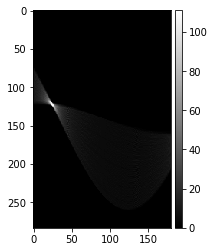

In [8]:
accumulator_mini, thetas_mini, radii_mini = houghtrans(mini_img_edge)

plotimg(accumulator_mini) 

The accumulator is characterised by a number of hotspots which contain the theta and radius locations which have the most number of votes. They are the spots where the must number of lines past through. As we only have one line, we should only get one spot, which indeed is what we have. We just want the theta and radius value for the point which has the highest value. 

Index of Theta at Maximum value: 24
Index of Radius at Maximum value: 121


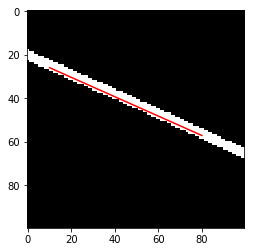

In [10]:
theta_i_max = np.argmax(np.max(accumulator_mini, axis=0))
radius_i_max = np.argmax(np.max(accumulator_mini, axis=1))

print("Index of Theta at Maximum value:", theta_i_max)
print("Index of Radius at Maximum value:", radius_i_max)

# extract the values of theta and radius at the maximum value
theta_max = thetas_mini[theta_i_max]
rad_max = radii_mini[radius_i_max]

# get the slope and intercept
m = -np.cos(theta_max)/np.sin(theta_max)
c = rad_max/ np.sin(theta_max)

# plot the line out from the m and c values
x1 = 10
x2 = 80
line = np.array([[m*x1+c, m*x2+c],
                 [x1, x2]])

plt.imshow(mini_img_edge, 'gray')
plt.plot(line[1, :], line[0, :], 'r')
plt.show()

Awesome! We have a line mapped on to the line in the image. Now we need to do this for all the bigger image. Lets get the accumulator and see what it looks like.

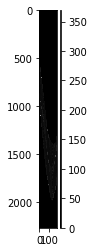

In [11]:
accumulator, thetas, radii = houghtrans(img_edge)

plotimg(accumulator)

That takes a long time. We couldn't be doing that online. The plot is squished because we have a lot more points for the radius than for the angles. Lets stretch the plot a bit.

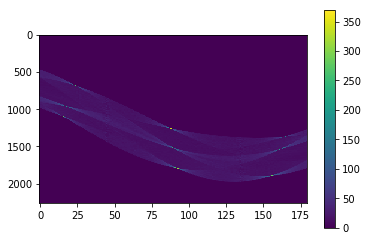

In [12]:
plt.imshow(accumulator, aspect=0.05)
plt.colorbar()
plt.show()

Interesting. The curve is in the form of a sinusoid. The hotspots are not as distinct as for just a single line, but we still see some hotspots. Lets try and extract the points with the highest value, and plot the line. Once we achieve that we can then find the other lines. This will be much harder to do!

Index of Theta at Maximum value: 90
Index of Radius at Maximum value: 1530


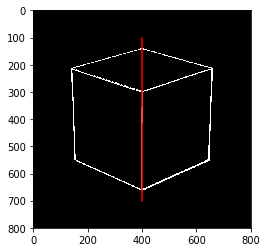

In [13]:
theta_i_max = np.argmax(np.max(accumulator, axis=0))
radius_i_max = np.argmax(np.max(accumulator, axis=1))

print("Index of Theta at Maximum value:", theta_i_max)
print("Index of Radius at Maximum value:", radius_i_max)

# extract the values of theta and radius at the maximum value
theta_max = thetas[theta_i_max]
radius_max = radii[radius_i_max]

# get the slope and intercept
# check if the line is unbounded
if theta_max == 0:
    line = np.array([[100, 700],
                     [radius_max, radius_max]])
# if not
else:
    m = -np.cos(theta_max)/np.sin(theta_max)
    c = radius_max/ np.sin(theta_max)

    # plot the line out from the m and c values
    x1 = 0
    x2 = 300
    line = np.array([[m*x1+c, m*x2+c],
                     [x1, x2]])

plt.imshow(img_edge, 'gray')
plt.plot(line[1, :], line[0, :], 'r')
plt.show()

Great, we have that nicely sorted. Now just to find the other lines which bound the cube. To do this, we will reshape the array into a 3 by N matrix, where N is the total number of points. The dimensions stored in the array are the radius, theta and count. We can then rank the by the count, and extract the radius and theta values for the L largest count in the accumulator. Lets take L to be 20 to start off with. 

In [19]:
# make up the new accumulator matrix, with total number of points N
N = len(thetas)*len(radii)
acc_matrix = np.zeros((3, N))

# cycle through, where n is a iterator, to define column index
n = 0
for index_theta in range(len(thetas)):
    for index_radius in range(len(radii)):
        acc_matrix[0, n] = radii[index_radius]
        acc_matrix[1, n] = thetas[index_theta]
        acc_matrix[2, n] = accumulator[index_radius, index_theta]
        n += 1
        
# L largest counts in the accumulator 
L = 40

# find the indices of the L largest values, and make an array to collect them
max_index = acc_matrix[2,:].argsort()[-L:][::-1]
max_values = np.zeros((3, L))

# cycle through and populate the array
for i in range(len(max_index)):
    max_i = max_index[i]
    max_values[0, i] = acc_matrix[0, max_i]
    max_values[1, i] = acc_matrix[1, max_i]
    max_values[2, i] = acc_matrix[2, max_i]

With those points found lets try and cluster them to find out what we have.

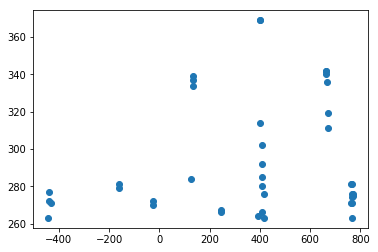

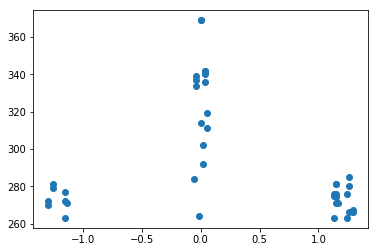

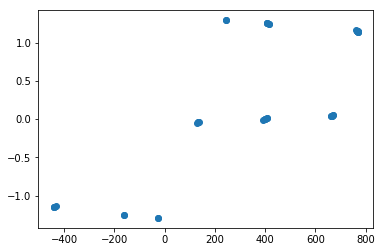

In [20]:
plt.plot(max_values[0, :], max_values[2, :], 'o')
plt.show()

plt.plot(max_values[1, :], max_values[2, :], 'o')
plt.show()

plt.plot(max_values[0, :], max_values[1, :], 'o')
plt.show()

In [21]:
# acceptable ranges to be same cluster
theta_diff = 0.1
radius_diff = 50

# number of points to check
D, num_points = max_values.shape

# first cluster point
means = max_values[:, 0]
means = means.reshape((3,1))
# number of clusters
N_points = 1

# iterate through the points in the max values list
for p in range((int(num_points))):
    # extract the point from the array
    point_p = max_values[:, p]
    point_p = point_p.reshape((3,1))
    # in_set_count changes if its in the means array. 0 means not in.
    in_set_count = 0
    
    # determine the number of cluster points
    D, N_points = means.shape
    # iterate through all the cluster points we have
    for i in range(0, N_points):
        # extract the ith mean value for the cluster point
        point_i = means[:, i]
        point_i = point_i.reshape((3,1))
        # calculate the differences between point i and point p
        point_dif = np.abs(point_p - point_i)
        # if the differences are within limits then change the mean
        if point_dif[0, 0] < radius_diff and point_dif[1, 0] < theta_diff:
# change the mean
            # the value is in the array, and in_set_count = 1
            in_set_count = 1
    
    # if point p not in array of means, in_set_count = 0, i.e. its new and need to append 
    if in_set_count == 0:
        means = np.append(means, point_p, axis = 1)
            

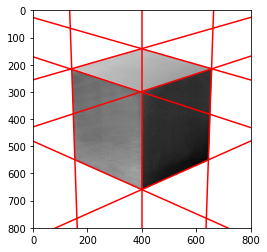

In [23]:
plt.imshow(img, 'gray')
img_ylim, img_xlim = img.shape
plt.xlim(0, img_xlim)
plt.ylim(img_ylim, 0)

D, N_lines = means.shape
lines_matrix = np.ones((3,N_lines))
for l in range(N_lines):
    rad = means[0, l]
    theta = means[1, l]
    if theta != 0:
        # get the slope and intercept
        m = -np.cos(theta) / np.sin(theta)
        c = rad / np.sin(theta)
        x1 = 0
        x2 = 800
        line = np.array([[m*x1+c, m*x2+c],
                        [x1, x2]])
        plt.plot(line[1, :], line[0, :], 'r')
        lines_matrix[0, l] = -1
        lines_matrix[1, l] = m
        lines_matrix[2, l] = c
    
    elif theta == 0:
        line = np.array([[0, 800],
                        [rad, rad]])
        
        plt.plot(line[1, :], line[0, :], 'r')
        
plt.show()

Great, we have the lines, but what we actually want is to have the red lines only for where there is an actual edge, and more ideally we would actually get the corners, as those are really the points of interest.

The solution here is to trace along the lines we discovered in the Hough edge detected image, and if the edge image has a pixel value equal to 1, we have a point on the edge. We then only want the x and y coordinates at a value of maximum and minimum x for each line. I will save this for the next installment. For now, we have shown how you find the edges, and trace through to show them on the original image.